In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_customer = pd.read_csv("Customer.csv", delimiter=";")
df_product = pd.read_csv("Product.csv", delimiter=";")
df_store = pd.read_csv("Store.csv", delimiter=";")
df_transaction = pd.read_csv("Transaction.csv", delimiter=";")

In [3]:
df_customer.shape, df_product.shape, df_store.shape, df_transaction.shape

((447, 5), (10, 3), (14, 6), (5020, 8))

In [4]:
df = pd.merge(pd.merge(pd.merge(df_customer, df_transaction, on='CustomerID'), df_product, on='ProductID'), df_store, on='StoreID')
df = df.drop(columns = "Price_y")
df.rename(columns={'Price_x': 'Price'}, inplace=True)
df

,CustomerID,Age,Gender,Marital Status,Income,TransactionID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,1,55,1,Married,"5,12",TR54475,23/02/2022,P8,16000,1,16000,9,Oat,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
1,5,58,1,Married,"3,57",TR53643,22/05/2022,P8,16000,3,48000,9,Oat,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
2,7,31,0,Married,"4,57",TR5151,10/03/2022,P8,16000,2,32000,9,Oat,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
3,19,24,1,Single,"4,14",TR98635,18/06/2022,P8,16000,1,16000,9,Oat,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
4,28,55,0,Married,"6,08",TR9420,12/01/2022,P8,16000,3,48000,9,Oat,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,403,30,0,Married,"4,06",TR21751,07/10/2022,P9,10000,5,50000,7,Yoghurt,Buana Indah,Buana,General Trade,"3,316694","114,590111"
5016,410,55,1,Married,"8,68",TR86692,05/04/2022,P9,10000,2,20000,7,Yoghurt,Buana Indah,Buana,General Trade,"3,316694","114,590111"
5017,411,19,1,Single,0,TR67993,23/10/2022,P9,10000,2,20000,7,Yoghurt,Buana Indah,Buana,General Trade,"3,316694","114,590111"
5018,427,54,0,Married,"16,88",TR28578,30/10/2022,P9,10000,3,30000,7,Yoghurt,Buana Indah,Buana,General Trade,"3,316694","114,590111"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      5020 non-null   int64 
 1   Age             5020 non-null   int64 
 2   Gender          5020 non-null   int64 
 3   Marital Status  4976 non-null   object
 4   Income          5020 non-null   object
 5   TransactionID   5020 non-null   object
 6   Date            5020 non-null   object
 7   ProductID       5020 non-null   object
 8   Price           5020 non-null   int64 
 9   Qty             5020 non-null   int64 
 10  TotalAmount     5020 non-null   int64 
 11  StoreID         5020 non-null   int64 
 12  Product Name    5020 non-null   object
 13  StoreName       5020 non-null   object
 14  GroupStore      5020 non-null   object
 15  Type            5020 non-null   object
 16  Latitude        5020 non-null   object
 17  Longitude       5020 non-null   object
dtypes: int64

In [6]:
df['Income'] = df['Income'].replace('[,]', '.', regex=True).astype('float')
df['Latitude'] = df['Latitude'].replace('[,]', '.', regex=True).astype('float')
df['Longitude'] = df['Longitude'].replace('[,]', '.', regex=True).astype('float')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', dayfirst=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   CustomerID      5020 non-null   int64         
 1   Age             5020 non-null   int64         
 2   Gender          5020 non-null   int64         
 3   Marital Status  4976 non-null   object        
 4   Income          5020 non-null   float64       
 5   TransactionID   5020 non-null   object        
 6   Date            5020 non-null   datetime64[ns]
 7   ProductID       5020 non-null   object        
 8   Price           5020 non-null   int64         
 9   Qty             5020 non-null   int64         
 10  TotalAmount     5020 non-null   int64         
 11  StoreID         5020 non-null   int64         
 12  Product Name    5020 non-null   object        
 13  StoreName       5020 non-null   object        
 14  GroupStore      5020 non-null   object        
 15  Type

### Mengecek dan Mengatasi Missing Value

In [8]:
df.isnull().sum()

CustomerID         0
Age                0
Gender             0
Marital Status    44
Income             0
TransactionID      0
Date               0
ProductID          0
Price              0
Qty                0
TotalAmount        0
StoreID            0
Product Name       0
StoreName          0
GroupStore         0
Type               0
Latitude           0
Longitude          0
dtype: int64

In [9]:
# Membuat array nilai yang tersedia di kolom 'Marital Status'
available_values = df['Marital Status'].dropna().unique()

# Mengganti setiap nilai yang hilang dengan nilai acak dari array nilai yang tersedia
for index, row in df.iterrows():
    if pd.isnull(row['Marital Status']):
        df.at[index, 'Marital Status'] = np.random.choice(available_values)

In [10]:
# Mengecek missing value setelah dilakukan pembersihan
df.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    0
Income            0
TransactionID     0
Date              0
ProductID         0
Price             0
Qty               0
TotalAmount       0
StoreID           0
Product Name      0
StoreName         0
GroupStore        0
Type              0
Latitude          0
Longitude         0
dtype: int64

### Mengecek dan Mengatasi Data Duplicate

In [11]:
# Mengecek nilai unik dari setiap kolom
df.nunique()

CustomerID         447
Age                 54
Gender               2
Marital Status       2
Income             369
TransactionID     4908
Date               365
ProductID           10
Price               10
Qty                 10
TotalAmount         44
StoreID             14
Product Name        10
StoreName           12
GroupStore           7
Type                 2
Latitude            14
Longitude           14
dtype: int64

In [12]:
df['TransactionID'].value_counts()

TransactionID
TR71313    3
TR74019    2
TR38919    2
TR87715    2
TR54287    2
          ..
TR63136    1
TR11280    1
TR7587     1
TR5274     1
TR28578    1
Name: count, Length: 4908, dtype: int64

In [13]:
# Menghapus data duplikat berdasarkan kolom 'TransactionID', dengan mempertahankan baris terakhir
df.drop_duplicates(subset=['TransactionID'], keep='last', inplace=True)

In [14]:
df['TransactionID'].value_counts()

TransactionID
TR54475    1
TR74254    1
TR95040    1
TR8182     1
TR47837    1
          ..
TR15464    1
TR25829    1
TR29269    1
TR26836    1
TR88485    1
Name: count, Length: 4908, dtype: int64

# **Forecasting**

In [15]:
df_regression = df.groupby('Date')['Qty'].sum().reset_index()
df_regression

,Date,Qty
0,2022-01-01,49
1,2022-01-02,59
2,2022-01-03,63
3,2022-01-04,43
4,2022-01-05,30
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,41


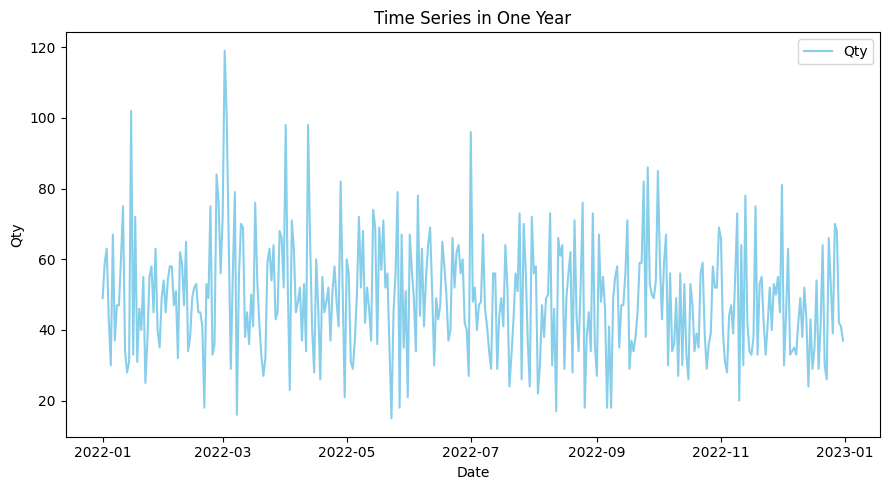

In [16]:
fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df_regression['Date'], df_regression['Qty'], color='skyblue', label='Qty')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Time Series in One Year')
plt.legend()
plt.tight_layout()
plt.show()

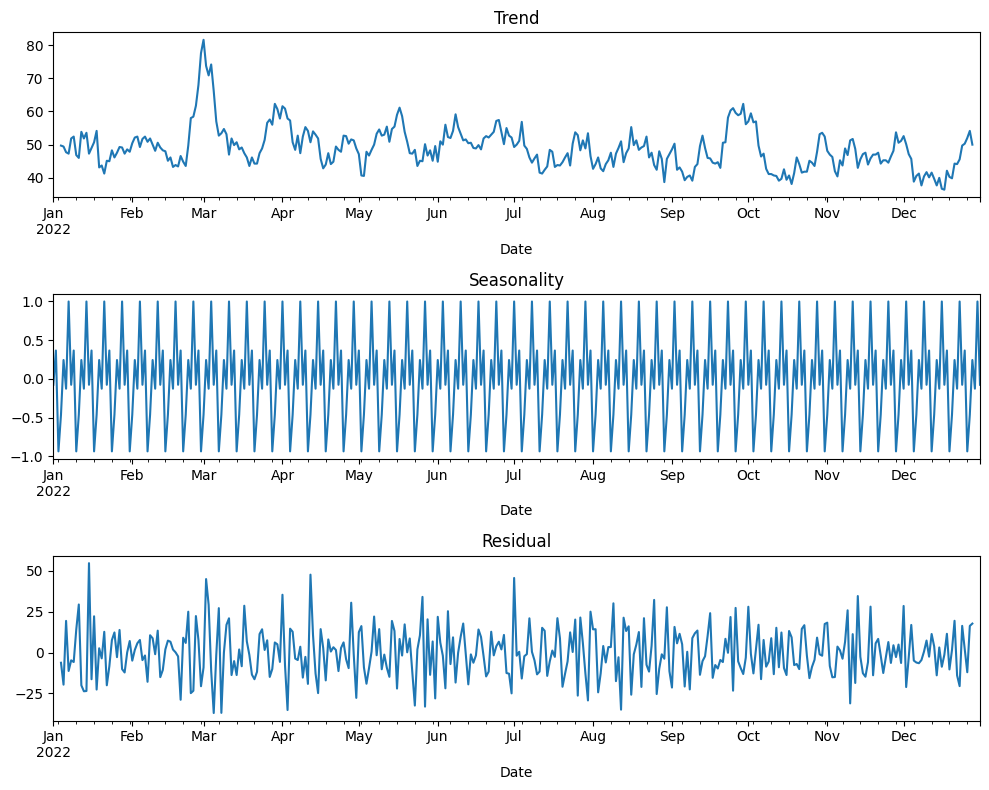

In [17]:
# Melakukan dekomposisi data
decomposed = seasonal_decompose(df_regression.set_index('Date'))

# Menampilkan plot tren menggunakan dekomposisi
plt.figure(figsize=(10, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residual')

plt.tight_layout()
plt.show()


In [18]:
# Melakukan uji stasioneritas menggunakan Augmented Dickey-Fuller (ADF) test
result = adfuller(df_regression['Qty'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

if result[1] <= 0.05:
  print("\nThe data is stationary")
else:
  print("\nThe data is non-stationary")


ADF Statistic: -19.131655296406304
p-value: 0.0
Critical Values:
	1%: -3.4484434475193777
	5%: -2.869513170510808
	10%: -2.571017574266393

The data is stationary


<Figure size 1200x600 with 0 Axes>

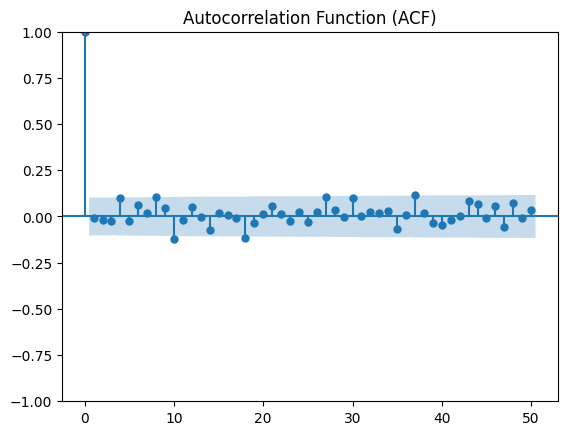

<Figure size 1200x600 with 0 Axes>

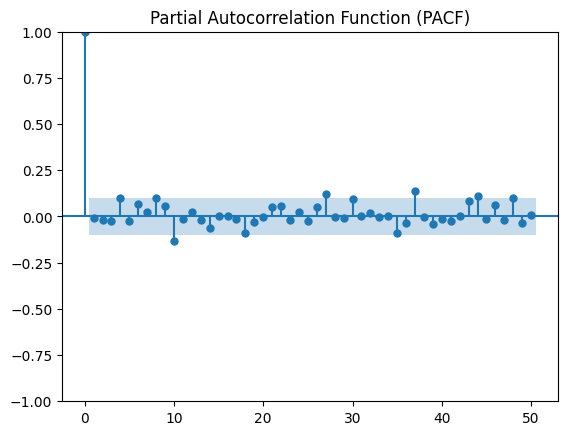

In [19]:
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(df_regression['Qty'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(df_regression['Qty'], lags=50, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


In [20]:
# Membagi dataset menjadi data train dan data test
cut_off = round(df_regression.shape[0] * 0.8) 
df_train = df_regression[:cut_off]
df_test = df_regression[cut_off:].reset_index(drop=True)

In [21]:
df_train

,Date,Qty
0,2022-01-01,49
1,2022-01-02,59
2,2022-01-03,63
3,2022-01-04,43
4,2022-01-05,30
...,...,...
287,2022-10-15,33
288,2022-10-16,26
289,2022-10-17,53
290,2022-10-18,47


In [22]:
df_test

,Date,Qty
0,2022-10-20,39
1,2022-10-21,35
2,2022-10-22,56
3,2022-10-23,59
4,2022-10-24,39
...,...,...
68,2022-12-27,70
69,2022-12-28,68
70,2022-12-29,42
71,2022-12-30,41


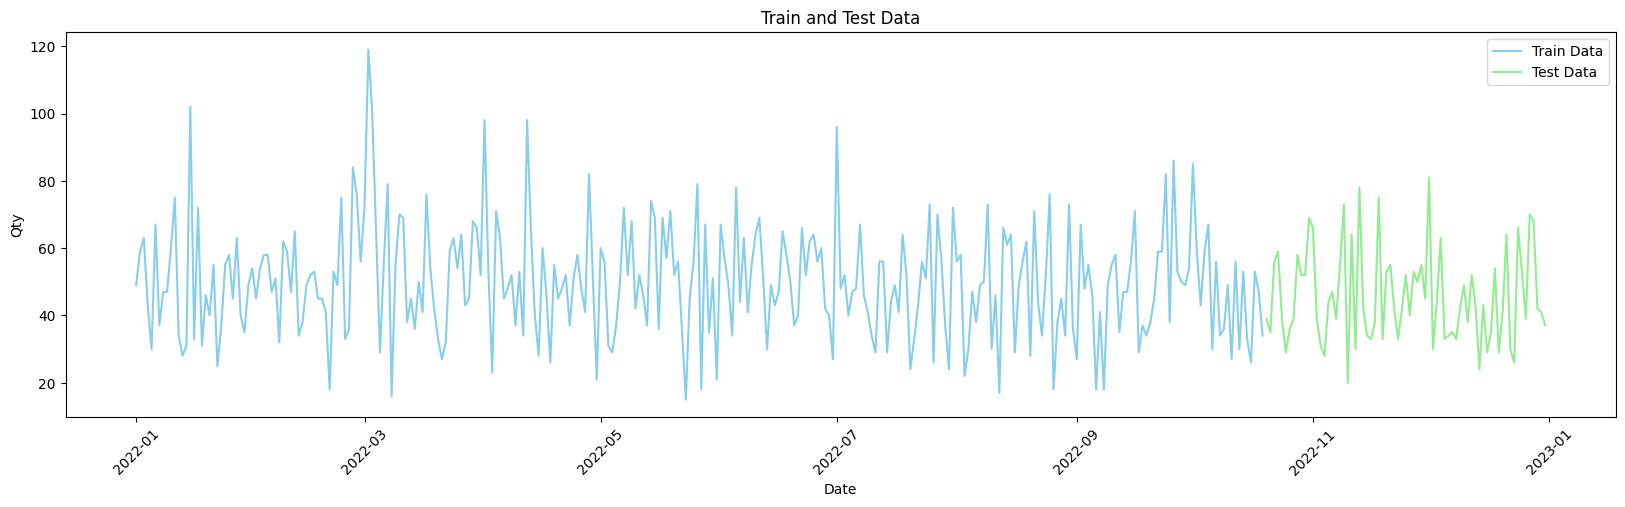

In [23]:
# Plot data train dan data test
plt.figure(figsize=(20, 5))
plt.plot(df_train['Date'], df_train['Qty'], label='Train Data', color='skyblue')
plt.plot(df_test['Date'], df_test['Qty'], label='Test Data', color='lightgreen')
plt.title('Train and Test Data')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.xticks(rotation=45)  
plt.show()

## ARIMA

In [25]:
# Membangun model ARIMA dengan parameter yang telah ditetapkan
model = sm.tsa.ARIMA(df_train['Qty'], order=(4, 0, 8))
model_fit = model.fit()

# Menampilkan ringkasan model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                    Qty   No. Observations:                  292
Model:                 ARIMA(4, 0, 8)   Log Likelihood               -1223.869
Date:                Sun, 29 Oct 2023   AIC                           2475.738
Time:                        11:07:49   BIC                           2527.213
Sample:                             0   HQIC                          2496.357
                                - 292                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.8212      1.173     42.487      0.000      47.523      52.119
ar.L1          0.1115      0.133      0.839      0.402      -0.149       0.372
ar.L2         -1.3907      0.133    -10.456      0.0

In [26]:
# Membuat prediksi dengan model yang telah dibangun
arima = model_fit.forecast(steps=len(df_test))  

# Menampilkan hasil prediksi
print(arima)


292    46.899605
293    48.886573
294    47.290773
295    51.513628
296    48.438843
         ...    
360    49.802708
361    49.834586
362    49.831317
363    49.805676
364    49.818729
Name: predicted_mean, Length: 73, dtype: float64


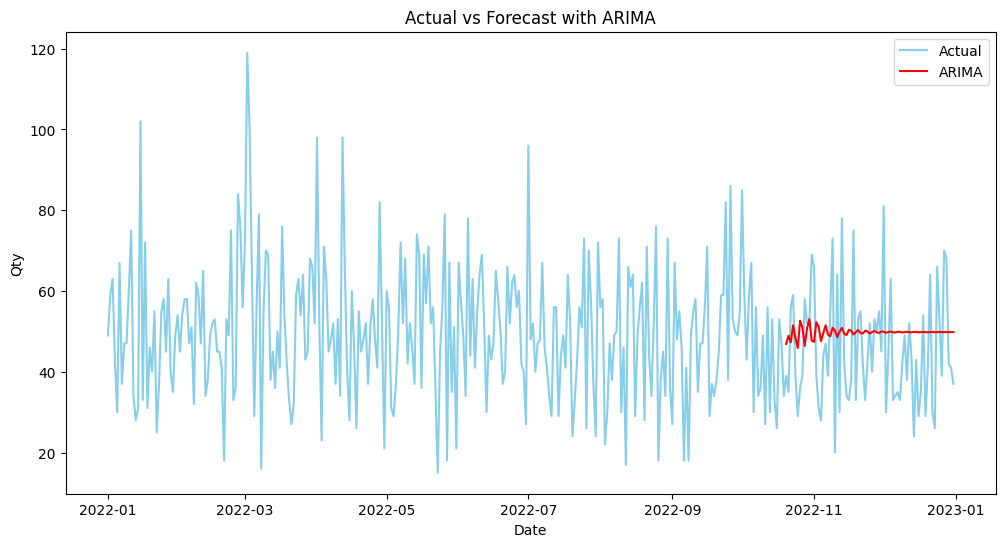

In [27]:
# Plot hasil ARIMA 
plt.figure(figsize=(12,6))
plt.plot(df_regression['Date'], df_regression['Qty'], label='Actual', color='skyblue')
plt.plot(df_test['Date'], arima, label='ARIMA', color='red')
plt.title('Actual vs Forecast with ARIMA')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.show()

## SARIMAX

In [39]:
# Membangun model SARIMAX dengan parameter yang telah ditetapkan
modelSARIMAX = sm.tsa.statespace.SARIMAX(df_train['Qty'], order=(0,1,1), seasonal_order=(0,1,1,110))
model_fit_SARIMAX = modelSARIMAX.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91018D+00    |proj g|=  1.35791D-01


 This problem is unconstrained.



At iterate    5    f=  2.85327D+00    |proj g|=  6.46610D-03

At iterate   10    f=  2.82789D+00    |proj g|=  6.72939D-03

At iterate   15    f=  2.82693D+00    |proj g|=  2.75427D-04

At iterate   20    f=  2.82691D+00    |proj g|=  3.02073D-05

At iterate   25    f=  2.82689D+00    |proj g|=  1.70462D-04

At iterate   30    f=  2.82686D+00    |proj g|=  4.15005D-05

At iterate   35    f=  2.82686D+00    |proj g|=  1.73366D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     36     42      1     0     0   8.934D-07   2.827D+00
  F =   2.8268571512358314     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

In [40]:
# Menampilkan hasil AIC
aic_value = model_fit_SARIMAX.aic
print(aic_value)


1656.8845763217255


In [41]:
# Membuat prediksi dengan model yang telah dibangun
forecast_SARIMAX = model_fit_SARIMAX.forecast(steps=len(df_test))  

# Menampilkan hasil prediksi
print(forecast_SARIMAX)

292    38.558769
293    47.378492
294    36.833185
295    57.337188
296    47.243729
         ...    
360    36.537034
361    38.791588
362    36.915003
363    49.004802
364    44.057146
Name: predicted_mean, Length: 73, dtype: float64


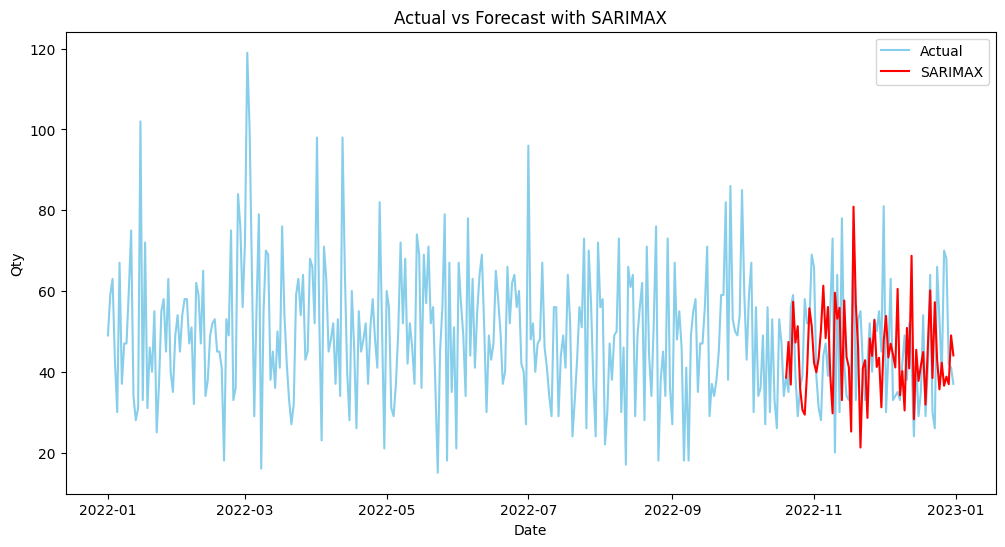

In [44]:
# Plot hasil Forecasting SARIMAX
plt.figure(figsize=(12,6))
plt.plot(df_regression['Date'], df_regression['Qty'], label='Actual', color = 'skyblue')
plt.plot(df_test['Date'], forecast_SARIMAX, label='SARIMAX', color='red')
plt.title('Actual vs Forecast with SARIMAX')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.show()

In [32]:
model_forecast_SARIMAX = sm.tsa.statespace.SARIMAX(df_regression['Qty'], order=(0,1,1), seasonal_order=(0,1,1,110))
model_fit_forecast_SARIMAX = model_forecast_SARIMAX.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24582D+00    |proj g|=  2.16779D-01


 This problem is unconstrained.



At iterate    5    f=  3.17064D+00    |proj g|=  3.10619D-02

At iterate   10    f=  3.12345D+00    |proj g|=  1.71436D-02

At iterate   15    f=  3.12088D+00    |proj g|=  6.45626D-04

At iterate   20    f=  3.12073D+00    |proj g|=  1.76659D-04

At iterate   25    f=  3.12069D+00    |proj g|=  4.82263D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     31      1     0     0   8.169D-06   3.121D+00
  F =   3.1206801868492020     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [33]:
# Melakukan forecasting menggunakan SARIMX untuk 110 hari kedepan
forecast_SARIMAX_next = model_fit_forecast_SARIMAX.forecast(steps=110)  

# Menampilkan hasil prediksi
print(forecast_SARIMAX_next)

365    53.373956
366    34.386205
367    47.393454
368    51.724350
369    42.026450
         ...    
470    44.159762
471    44.180217
472    36.155051
473    45.133689
474    41.121239
Name: predicted_mean, Length: 110, dtype: float64


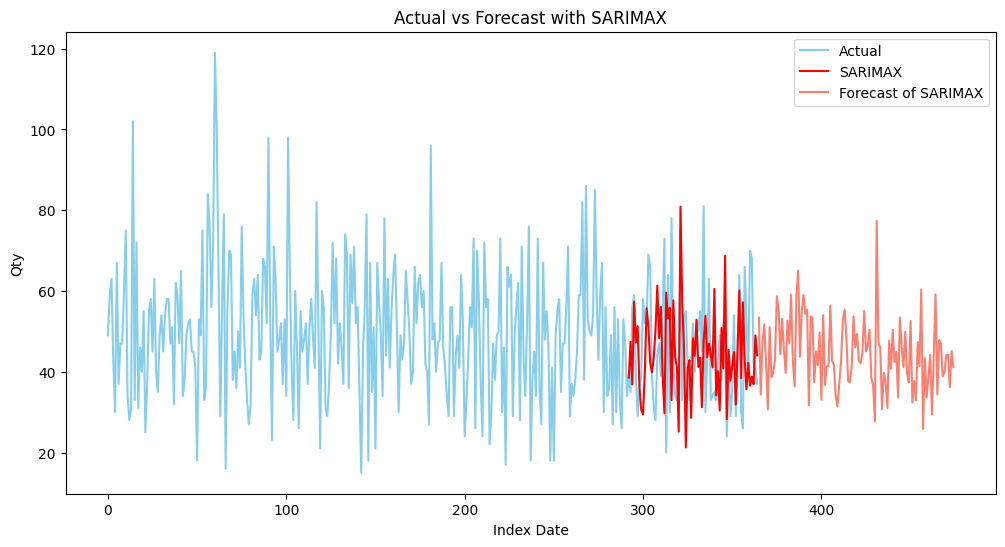

In [43]:
# Plot hasil Forecasting SARIMAX
plt.figure(figsize=(12,6))
plt.plot(df_regression['Qty'], label='Actual', color='skyblue')
plt.plot(forecast_SARIMAX, label='SARIMAX', color='red')
plt.plot(forecast_SARIMAX_next, label='Forecast of SARIMAX', color='salmon')
plt.title('Actual vs Forecast with SARIMAX')
plt.xlabel('Index Date')
plt.ylabel('Qty')
plt.legend()
plt.show()

# **Clustering**

In [116]:
clustering_data = df.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'Qty': 'sum',
    'TotalAmount': 'sum'}).reset_index()
clustering_data = pd.DataFrame(clustering_data)
clustering_data

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,12,56,382300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600
...,...,...,...,...
442,443,15,54,410100
443,444,18,62,577700
444,445,18,68,587200
445,446,11,42,423300


In [117]:
clustering_data.nunique()

CustomerID       447
TransactionID     19
Qty               61
TotalAmount      419
dtype: int64

In [118]:
clustering_data = clustering_data.drop(columns='CustomerID', axis=1)
clustering_data

,TransactionID,Qty,TotalAmount
0,17,60,623300
1,12,56,382300
2,15,56,446200
3,10,46,302500
4,7,27,268600
...,...,...,...
442,15,54,410100
443,18,62,577700
444,18,68,587200
445,11,42,423300


In [119]:
# Inisialisasi scaler
scaler = MinMaxScaler()

# Normalisasi data
normalized_data = pd.DataFrame(scaler.fit_transform(clustering_data))
normalized_data = normalized_data.rename(columns={0: 'TransactionID', 1: 'Qty', 2: 'TotalAmount'})
normalized_data


,TransactionID,Qty,TotalAmount
0,0.777778,0.724638,0.707706
1,0.500000,0.666667,0.392385
2,0.666667,0.666667,0.475991
3,0.388889,0.521739,0.287976
4,0.222222,0.246377,0.243622
...,...,...,...
442,0.666667,0.637681,0.428758
443,0.833333,0.753623,0.648044
444,0.833333,0.840580,0.660474
445,0.444444,0.463768,0.446029


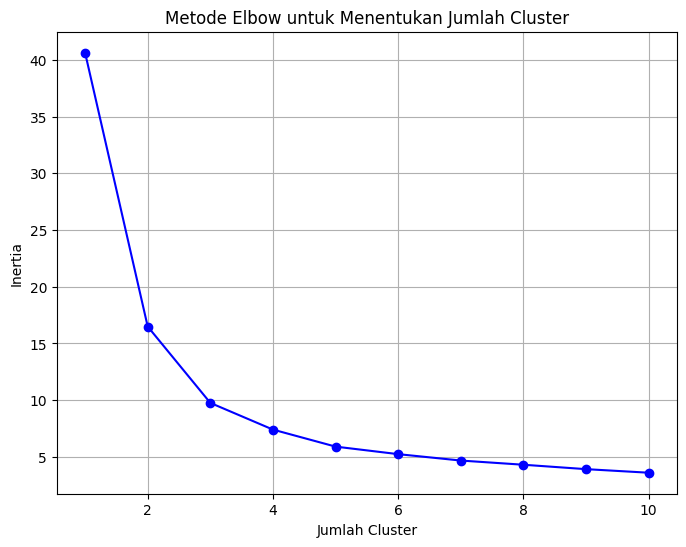

In [120]:
# Menentukan jumlah cluster (gunakan metode Elbow untuk memilih jumlah cluster yang optimal)
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init=10)
    kmeans.fit(normalized_data)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method untuk menentukan jumlah cluster yang optimal
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Inertia')
plt.title('Metode Elbow untuk Menentukan Jumlah Cluster')
plt.grid(True)
plt.show()

In [121]:
# Menentukan cluster yang paling optimal menggunakan KneeLocator
kl = KneeLocator(range(1, 11), inertia, curve="convex", direction="decreasing" )
kl.elbow

3

In [122]:
# Membuat 3 cluster
kmeans_3 = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0, n_init = 10)
clusters = kmeans_3.fit_predict(normalized_data)
clustering_data['Cluster'] = clusters
clustering_data.head()

,TransactionID,Qty,TotalAmount,Cluster
0,17,60,623300,0
1,12,56,382300,1
2,15,56,446200,0
3,10,46,302500,1
4,7,27,268600,2


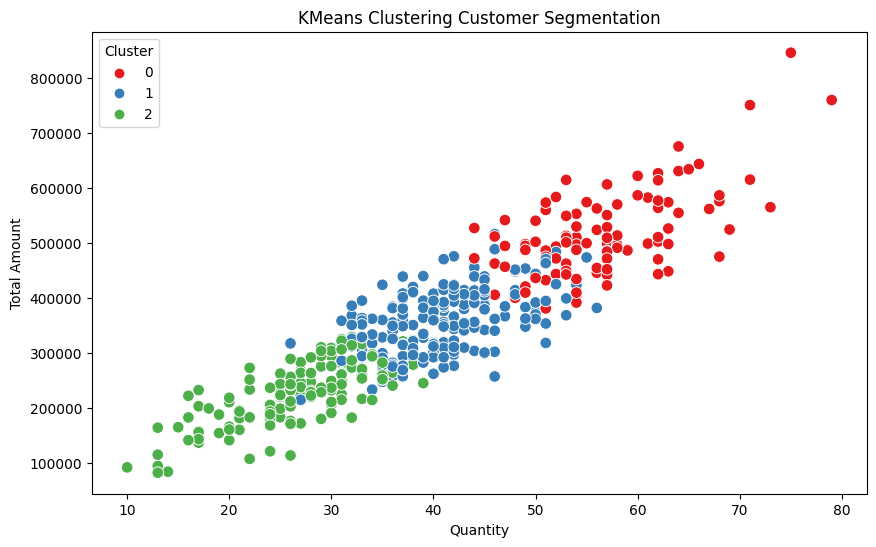

In [123]:
# Menampilkan hasil clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Qty', y='TotalAmount', data=clustering_data, hue='Cluster', palette='Set1', s=70)
plt.xlabel('Quantity')
plt.ylabel('Total Amount')
plt.title('KMeans Clustering Customer Segmentation')
plt.legend(title='Cluster')
plt.show()

In [124]:
# Menghitung jumlah data dalam setiap cluster
cluster_counts = clustering_data['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']
print(cluster_counts)

   Cluster  Count
0        1    201
1        2    142
2        0    104


## Customer Segmentation 

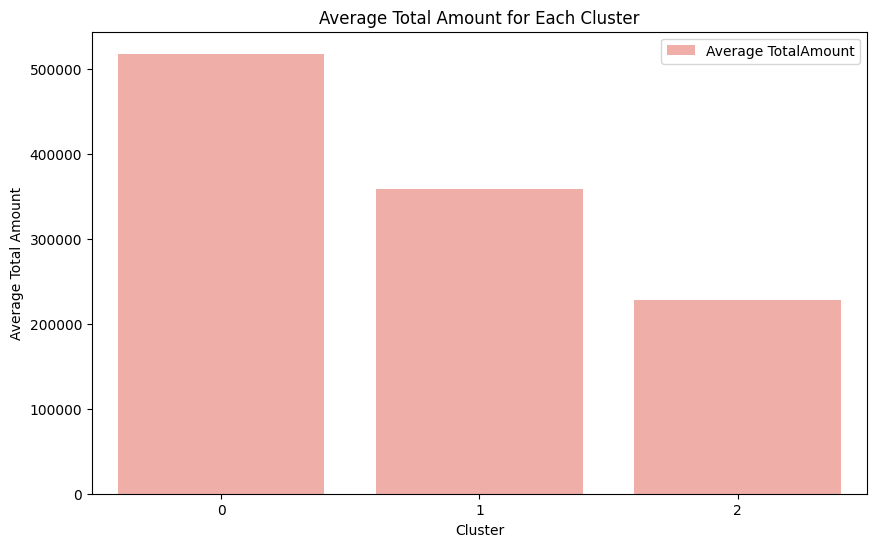

In [125]:
# Menghitung rata-rata Qty dan TotalAmount untuk setiap cluster
cluster_avg = clustering_data.groupby('Cluster').agg({
    'Qty': 'mean',
    'TotalAmount': 'mean'
}).reset_index()

# Menampilkan hasil 
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='TotalAmount', data=cluster_avg, color='salmon', alpha=0.7, label='Average TotalAmount')
plt.xlabel('Cluster')
plt.ylabel('Average Total Amount')
plt.title('Average Total Amount for Each Cluster')
plt.legend()
plt.show()


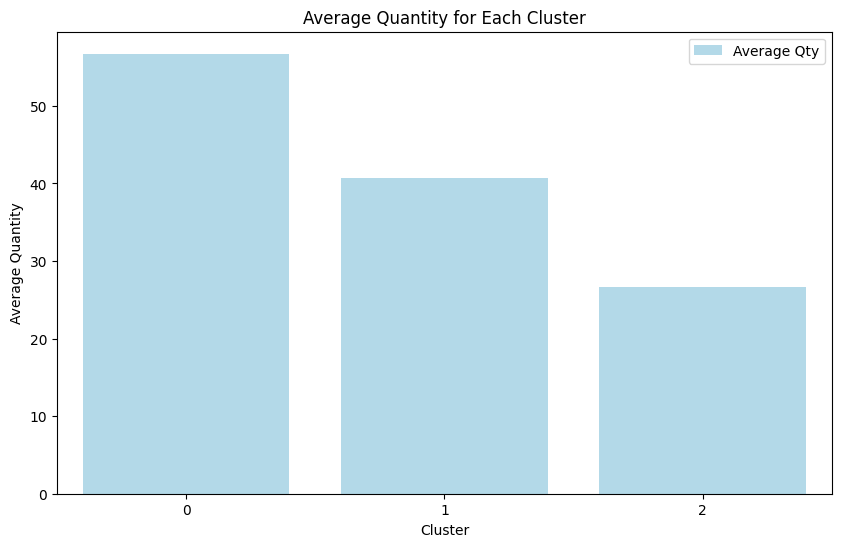

In [126]:
# Menampilkan hasil 
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Qty', data=cluster_avg, color='skyblue', alpha=0.7, label='Average Qty')
plt.xlabel('Cluster')
plt.ylabel('Average Quantity')
plt.title('Average Quantity for Each Cluster')
plt.legend()
plt.show()

#### **Karakteristik Customer :** 

1. Cluster 0 merupakan "Loyal Customer", hal ini dikarenakan rata-rata dari jumlah pembelian barang dan total pengeluaran nya paling besar.

2. Cluster 1 merupakan "Potential Loyal Customer, hal ini dikarenakan rata-rata dari jumlah pembelian barang dan total pengeluaran nya menengah. 

3. Cluster 2 merupakan "New Customer", hal ini dikarenakan rata-rata dari jumlah pembelian barang dan total pengeluaran nya paling sedikit.

#### **Rekomendasi Bisnis :**

**Cluster 0**

1. Mengembangkan program loyalitas yang menarik, seperti penghargaan poin setiap pembelian, diskon eksklusif, atau akses ke penawaran produk terbatas.

2. Melakukan komunikasi teratur dengan pelanggan melalui email, pesan teks, atau media sosial untuk mempertahankan keterikatan mereka dengan merek.

3. Melakukan survei kepuasan pelanggan secara teratur untuk memahami preferensi mereka dan memastikan kepuasan terus terjaga.

**Cluster 1**

1. Memberikan penawaran yang relevan dan menarik.

2. Mewarkan diskon berbasis pembelian sebelumnya atau program hadiah untuk mendorong pembelian berulang dan membangun loyalitas pelanggan.

3. Memastikan pelayanan pelanggan yang responsif dan ramah, tanggapi pertanyaan atau masukan mereka dengan cepat dan efisien.

**Cluster 2**

1. Memberikan diskon atau hadiah khusus saat pembelian pertama.

2. Melakukan follow-up setelah pembelian pertama, tanyakan tentang pengalaman mereka, dan pastikan bahwa mereka merasa dihargai dan dipedulikan.

3. Menawarkan program loyalitas yang memberikan poin reward setiap kali berbelanja, diskon eksklusif, dan akses ke penawaran khusus untuk member baru.
